In [1]:
using Distributions, Random, Plots, CurveFit, LinearAlgebra
Random.seed!(123)

TaskLocalRNG()

In [2]:
global const diffusivity = 1.00::Float64

global const endtime = 1.00::Float64
global const dt = 0.0001::Float64
global const timesteps = Int64(div(endtime,dt)+1)::Int64

global const spacesteps = 51::Int64

global const cls = (diffusivity*(spacesteps*spacesteps)/timesteps)::Float64


0.2601

### Diffusion equation 
$$\frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left( D\frac{\partial u}{\partial x}\right)$$

In [4]:
function Crank_Nicolson_step(A, B, u_inint)
    return A\(B*u_inint)
end

function CN_absorbing_BC(u_init, alpha)
    #A * U_n+1 = B * U_n
    n_steps = spacesteps-2

    A = Tridiagonal(fill(-alpha/2, n_steps-1),
                    fill(1+alpha, n_steps),
                    fill(-alpha/2, n_steps-1))

    B = Tridiagonal(fill(alpha/2, n_steps-1),
                    fill(1-alpha, n_steps),
                    fill(alpha/2, n_steps-1))


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for i in 2:timesteps
        res[i] = reduce(vcat, [0, Crank_Nicolson_step(A,B,res[i-1][2:end-1]),0])
    end
    return res
end 

function CN_reflecting_BC(u_init, alpha)
    #A * U_n+1 = B * U_n
    n_steps = size(u_init,1)

    A = Tridiagonal(reduce(vcat, [fill(-alpha/2, n_steps-2), -alpha]),
                        fill(1+alpha, n_steps),
                        reduce(vcat, [-alpha, fill(-alpha/2, n_steps-2)]))
    
    B = Tridiagonal(reduce(vcat, [fill(alpha/2, n_steps-2), alpha]),
                        fill(1-alpha, n_steps),
                        reduce(vcat, [alpha, fill(alpha/2, n_steps-2)]))

    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for i in 2:timesteps
        res[i] = Crank_Nicolson_step(A,B,res[i-1])
    end
    return res
end



CN_reflecting_BC (generic function with 1 method)

In [5]:
function u_analytical(consts, x, t)
    u0 = consts[1]
    x0 = consts[2]
    pref = u0/(sqrt(4*pi*diffusivity))
    return pref / t * exp(-(x-x0)^2/(4*diffusivity*t))
end

x = reduce(vcat, [0, cumsum(fill(1/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)



10000-element LinRange{Float64, Int64}:
 0.0, 0.00010001, 0.00020002, …, 0.9996, 0.9997, 0.9998, 0.9999, 1.0

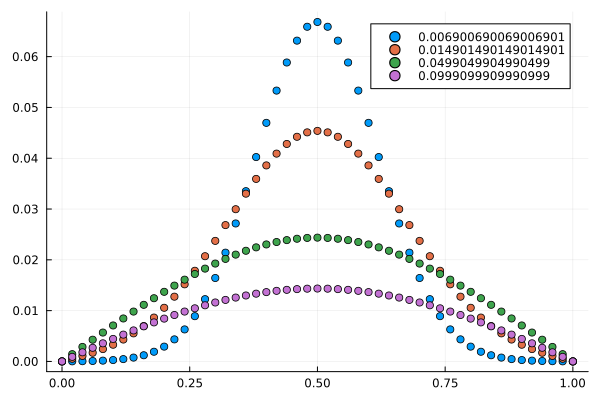

In [11]:
x = reduce(vcat, [0, cumsum(fill(1/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)+1] = 1

plot(scatter(x,CN_absorbing_BC(u_init, cls)[70], label = t[70]))
plot!(scatter!(x,CN_absorbing_BC(u_init, cls)[150], label = t[150]))
plot!(scatter!(x,CN_absorbing_BC(u_init, cls)[500], label = t[500]))
plot!(scatter!(x,CN_absorbing_BC(u_init, cls)[1000], label = t[1000]))


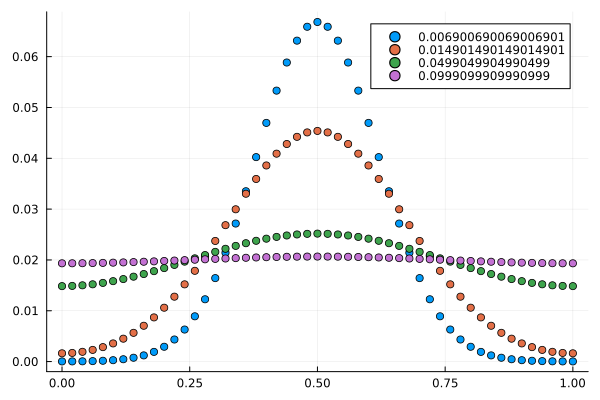

In [15]:
plot(scatter(x,CN_reflecting_BC(u_init, cls)[70], label = t[70]))
plot!(scatter!(x,CN_reflecting_BC(u_init, cls)[150], label = t[150]))
plot!(scatter!(x,CN_reflecting_BC(u_init, cls)[500], label = t[500]))
plot!(scatter!(x,CN_reflecting_BC(u_init, cls)[1000], label = t[1000]))